# 루브릭
1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?
    - KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.
2. U-Net++ 모델이 성공적으로 구현되었는가?
    - U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.
3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?
    - U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.

## 라이브러리 불러오기

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

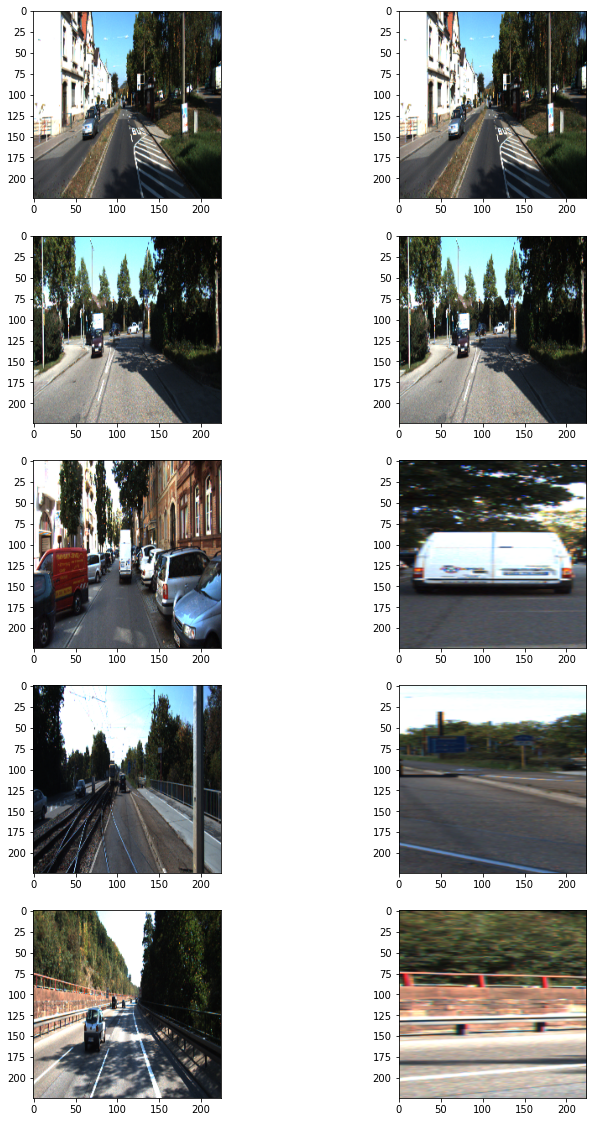

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 모델 구조 만들기(U-Net)

In [6]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
	
    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [7]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 71s 617ms/step - loss: 0.6857 - val_loss: 0.6614
Epoch 2/100
11/11 [==============================] - 6s 580ms/step - loss: 0.3939 - val_loss: 0.2820
Epoch 3/100
11/11 [==============================] - 6s 563ms/step - loss: 0.2841 - val_loss: 0.2819
Epoch 4/100
11/11 [==============================] - 6s 564ms/step - loss: 0.2577 - val_loss: 0.2819
Epoch 5/100
11/11 [==============================] - 6s 568ms/step - loss: 0.1825 - val_loss: 0.2819
Epoch 6/100
11/11 [==============================] - 6s 570ms/step - loss: 0.2784 - val_loss: 0.2819
Epoch 7/100
11/11 [==============================] - 6s 577ms/step - loss: 0.2223 - val_loss: 0.2819
Epoch 8/100
11/11 [==============================] - 6s 581ms/step - loss: 0.1936 - val_loss: 0.2819
Epoch 9/100
11/11 [==============================] - 7s 587ms/step - loss: 0.2550 - val_loss: 0.2819
Epoch 10/100
11/11 [==============================] - 7s 593ms/step - loss: 0.2373 - val_l

In [20]:
model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

In [21]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

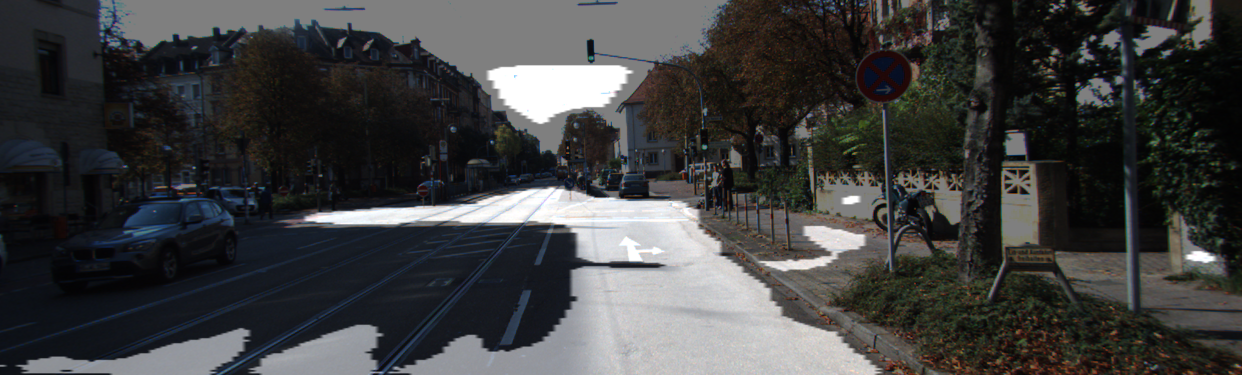

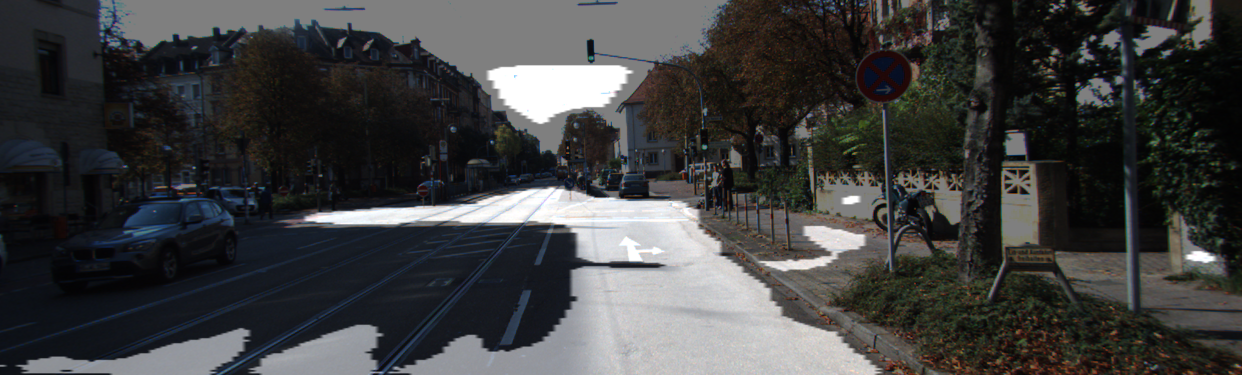

In [22]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [23]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [24]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

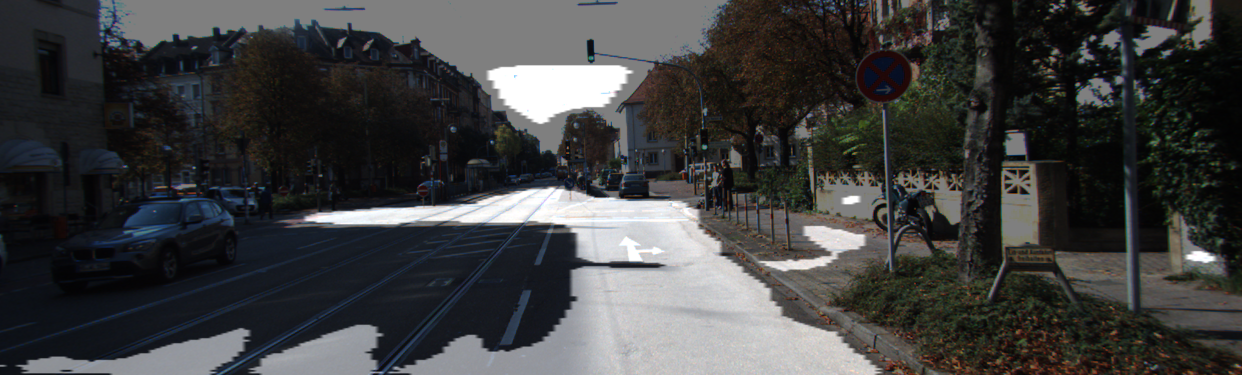

IoU : 0.419641


0.41964089410040306

In [25]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## U-Net++ 모델 구현하기

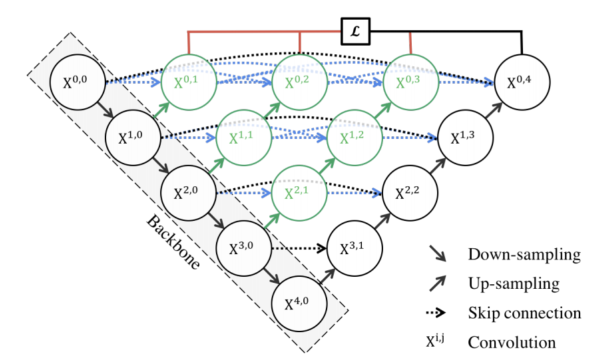
위의 그림을 참고하여 U-Net++ 모델을 만들어보겠습니다.

In [26]:
# conv block과 merge_block을 만들어 주도록 하겠습니다.
def conv(channel: int, inputs):
    conv = Conv2D(channel, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv = Conv2D(channel, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
    return conv

def up_merge(pre_up, channel: int, *conv):
    upsampling = Conv2DTranspose(channel, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(pre_up)
    merge = concatenate([*conv, upsampling], axis = 3)

    return merge

In [27]:
#위의 두 block을 이용해 U-Net++ model을 만들겠습니다.
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
        
    # backbone
    # X0, 0
    conv0_0 = conv(64, inputs)
    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0_0)
    # X1, 0
    conv1_0 = conv(128, pool0)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
    # X2, 0
    conv2_0 = conv(256, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
    # X3, 0
    conv3_0 = conv(512, pool2)
    drop3 = Dropout(0.5)(conv3_0)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    # X4, 0
    conv4_0 = conv(1024, pool3)
    drop4 = Dropout(0.5)(conv4_0)
    

    # X0, 1
    merge0_1 = up_merge(conv1_0, 64, conv0_0)
    conv0_1 = conv(64, merge0_1)
    # X1, 1
    merge1_1 = up_merge(conv2_0, 128, conv1_0)
    conv1_1 = conv(128, merge1_1)
    # X2, 1
    merge2_1 = up_merge(conv3_0, 256, conv2_0)
    conv2_1 = conv(256, merge2_1)
    # X3, 1
    merge3_1 = up_merge(conv4_0, 512, conv3_0)
    conv3_1 = conv(512, merge3_1)


    # X0, 2
    merge0_2 = up_merge(conv1_1, 64, conv0_0, conv0_1)
    conv0_2 = conv(64, merge0_2)
    # X1, 2
    merge1_2 = up_merge(conv2_1, 128, conv1_0, conv1_1)
    conv1_2 = conv(128, merge1_2)
    # X2, 2
    merge2_2 = up_merge(conv3_1, 256, conv2_0, conv2_1)
    conv2_2 = conv(256, merge2_2)


    # X0, 3
    merge0_3 = up_merge(conv1_2, 64, conv0_0, conv0_1, conv0_2)
    conv0_3 = conv(64, merge0_3)
    # X1, 3
    merge1_3 = up_merge(conv2_2, 128, conv1_0, conv1_1, conv1_2)
    conv1_3 = conv(128, merge1_3)
    

    # X0, 4
    merge0_4 = up_merge(conv1_3, 64, conv0_0, conv0_1, conv0_2, conv0_3)
    conv0_4 = conv(64, merge0_4)

    conv0_4 = Conv2D(1, 1, activation='sigmoid')(conv0_4)

    model = Model(inputs = inputs, outputs = conv0_4)
    
    return model

### 모델 학습하기

In [29]:
model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
)

Epoch 1/100
11/11 [==============================] - 36s 2s/step - loss: 0.6822 - val_loss: 0.6484
Epoch 2/100
11/11 [==============================] - 19s 2s/step - loss: 0.4917 - val_loss: 0.0790
Epoch 3/100
11/11 [==============================] - 19s 2s/step - loss: 0.0664 - val_loss: 0.0312
Epoch 4/100
11/11 [==============================] - 18s 2s/step - loss: 0.0314 - val_loss: 0.0337
Epoch 5/100
11/11 [==============================] - 18s 2s/step - loss: 0.0331 - val_loss: 0.0410
Epoch 6/100
11/11 [==============================] - 18s 2s/step - loss: 0.0306 - val_loss: 0.0278
Epoch 7/100
11/11 [==============================] - 18s 2s/step - loss: 0.0269 - val_loss: 0.0259
Epoch 8/100
11/11 [==============================] - 18s 2s/step - loss: 0.0255 - val_loss: 0.0244
Epoch 9/100
11/11 [==============================] - 19s 2s/step - loss: 0.0300 - val_loss: 0.0320
Epoch 10/100
11/11 [==============================] - 19s 2s/step - loss: 0.0319 - val_loss: 0.0268
Epoch 11/

11/11 [==============================] - 19s 2s/step - loss: 0.0161 - val_loss: 0.0180
Epoch 84/100
11/11 [==============================] - 19s 2s/step - loss: 0.0108 - val_loss: 0.0176
Epoch 85/100
11/11 [==============================] - 19s 2s/step - loss: 0.0123 - val_loss: 0.0174
Epoch 86/100
11/11 [==============================] - 19s 2s/step - loss: 0.0103 - val_loss: 0.0177
Epoch 87/100
11/11 [==============================] - 18s 2s/step - loss: 0.0110 - val_loss: 0.0185
Epoch 88/100
11/11 [==============================] - 18s 2s/step - loss: 0.0109 - val_loss: 0.0170
Epoch 89/100
11/11 [==============================] - 18s 2s/step - loss: 0.0125 - val_loss: 0.0177
Epoch 90/100
11/11 [==============================] - 18s 2s/step - loss: 0.0108 - val_loss: 0.0180
Epoch 91/100
11/11 [==============================] - 18s 2s/step - loss: 0.0072 - val_loss: 0.0165
Epoch 92/100
11/11 [==============================] - 18s 2s/step - loss: 0.0145 - val_loss: 0.0179
Epoch 93/100


In [30]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

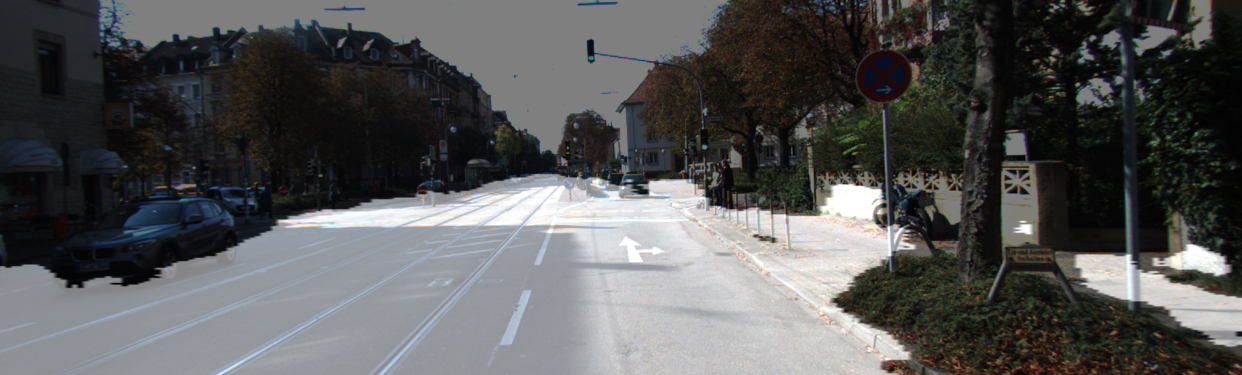

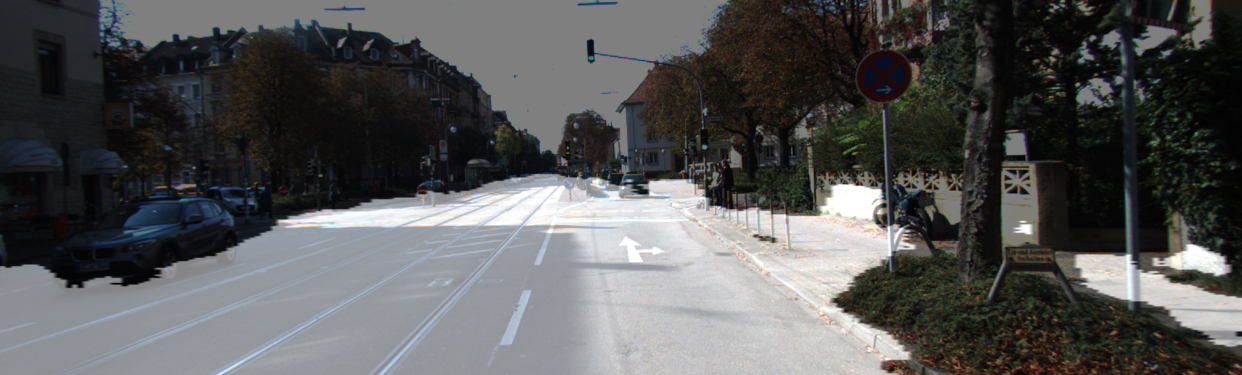

In [31]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [32]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [33]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

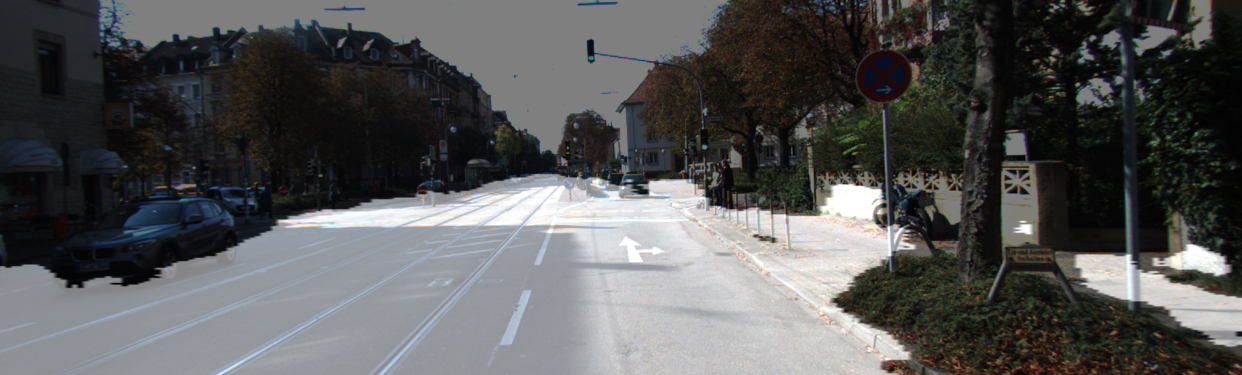

IoU : 0.791209


0.7912087912087912

In [34]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

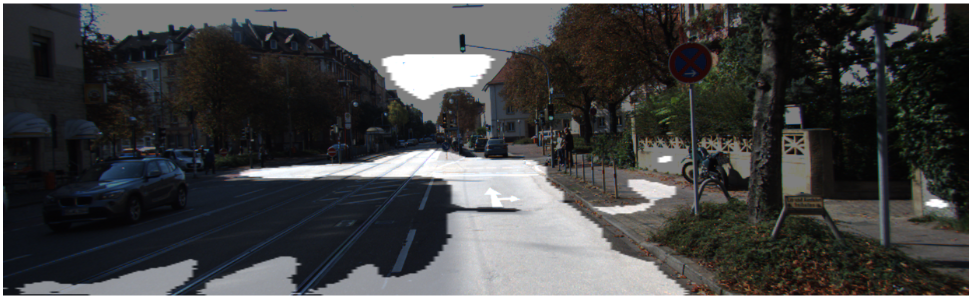 
IoU : 0.419641
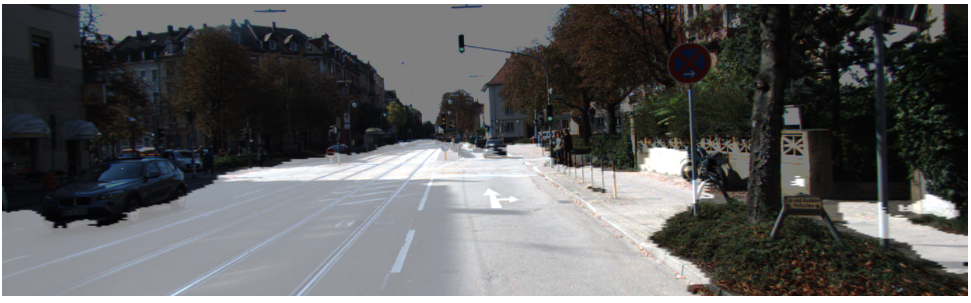
IoU : 0.791209

## 회고
 두 image를 비교만 해보아도 확실히 아래의 U-Net++를 이용했을 때의 성능이 확실히 좋음을 확인할 수 있습니다. 추가적으로 IoU 결과값을 보아도 0.38이라는 큰 결과가 차이나는 것을 확인할 수 있습니다. 모델 구현을 하는 것에 있어서 위의 구조 그림을 보면서 디자인을 하니 생각보다 덜 어려웠습니다. Detection 분야에 주된 관심을 가지고 있었지만 다른 task를 해보는 것도 도움이 되었으며, 특히 자율주행에 있어서 segmentation을 할 줄 알아야 한다고 생각하기 때문에 좋은 경험을 할 수 있었습니다.